In [1]:
#Capstone III
#Exploratory Data Analysis
#Ofri Oren

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show plots inline
%matplotlib inline

import datetime as dt
import os
import io 

#Image imports
import imageio.v3 as imageio
from scipy import ndimage as ndi
from skimage import filters, exposure, transform, morphology, restoration, util, segmentation, measure, feature
from PIL import Image
from skimage.draw import polygon

In [19]:
#First I will open the images and store the labels for the training data.

# Dictionary to store image and label data
img_data = {}

def open_labels_in_folder(folder_path):
    """Opens and stores all labels in the given folder."""
    labels = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            try:
                with open(filepath, 'r') as f:
                    label = f.read().strip()  # Read and strip any extra whitespace
                    labels[filename] = label
            except Exception as e:
                print(f"Error opening {filepath}: {e}")
    return labels

def open_images_in_folder(folder_path):
    """Opens and stores all images in the given folder."""
    images = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            filepath = os.path.join(folder_path, filename)
            try:
                img = imageio.imread(filepath)
                images[filename] = img  # Store image in dictionary with filename as key
            except Exception as e:
                print(f"Error opening {filepath}: {e}")
    return images

# Paths to folders
labels_folder_path = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/labels"
images_folder_path = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Load labels and images
labels = open_labels_in_folder(labels_folder_path)
images = open_images_in_folder(images_folder_path)

# Combine images and labels into a single dictionary (assuming filenames match)
for img_filename, img in images.items():
    # Match label file to image file by name (e.g., "image1.png" -> "image1.txt")
    label_filename = img_filename.rsplit('.', 1)[0] + '.txt'
    img_data[img_filename] = {
        'image': img,
        'label': labels.get(label_filename, None)  # Get label if exists, otherwise None
    }

# Example: Print the keys in img_data
print(f"Loaded {len(img_data)} image-label pairs.")


Loaded 102 image-label pairs.


In [20]:
# I'll get a quick view of all the keys from the dictionary.
img_key = list(img_data.keys())
print(img_key)

['glioma5_jpg.rf.9666e40a130e55d876a31b42b43bff12.jpg', 'glioma49_jpg.rf.9f1c925253a596fc72034d0109e7412e.jpg', 'glioma6_jpg.rf.c56e9abe8ce5d73c83b3e1159f98886f.jpg', 'meningioma20_jpg.rf.9ce8314aade0a44b066051b2d9e96a17.jpg', 'Tr-pi_1443_jpg.rf.7b25b18a464c79b3384c8457a3d3d667.jpg', 'glioma8_jpg.rf.d54a4342750326015e96200d736fad8d.jpg', 'Tr-piTr_0000_jpg.rf.a5fdc4ac03409741b9de345b7f578ad0.jpg', 'glioma30_jpg.rf.648d8cc07e543ab73fa22cb12895e3e8.jpg', 'glioma2_jpg.rf.edf2ebefd6a4d3c19d7601807ffc9a30.jpg', 'Tr-pi_1452_jpg.rf.1309a069a026dc94029227e46601888a.jpg', 'meningioma33_jpg.rf.b4918f3d3f97e0e0c36e359bfe1b3c4d.jpg', 'meningioma10_jpg.rf.24f870883d2b7d87c46ae6aefaf9827d.jpg', 'Tr-piTr_0003_jpg.rf.c666e364a6c405ab482f193bdf4c6a0d.jpg', 'glioma46_jpg.rf.ceb839e8baf9fb5eb7f5e8bdee18fa0e.jpg', 'Tr-piTr_0009_jpg.rf.5d5024f1ca5e7769e4a52ca5cf6e5c02.jpg', 'pituitary21_jpg.rf.28007013f53cc5d16983c8c8fc286ba9.jpg', 'meningioma2_jpg.rf.8ad0b09a38c5839cbd78629a564cd779.jpg', 'pituitary15_jpg.

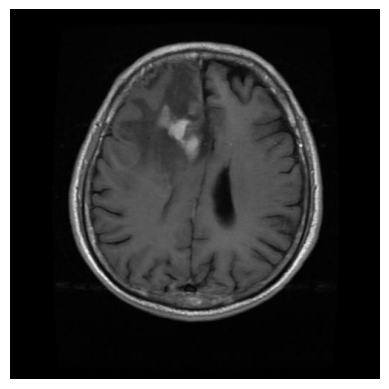

In [23]:
# I want to take a look at a sample image, so I'll look at the first image from the list of keys.
# Directly load the image from the file path
img_path = '/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images/glioma5_jpg.rf.9666e40a130e55d876a31b42b43bff12.jpg'
img = imageio.imread(img_path)

# Display the image
plt.imshow(img, cmap='gray')  
plt.axis('off') 
plt.show()

In [25]:
#Is it a large image and should I be careful of overloading while processing?
img.size

1228800

In [27]:
#I want to know what kind of image this is.
img.dtype

dtype('uint8')

Loaded volume shape: (102, 640, 640, 3)


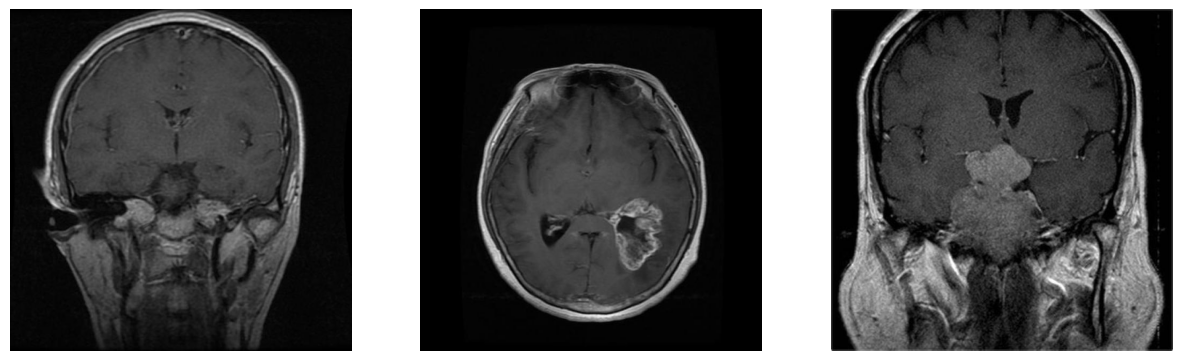

In [43]:
#I have all of the images stored with their labels in a dictionary, but for batch processing and viewing I will create 
# a volume.

folder_path = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Load all images in the folder as a volume
volume = []

for filename in sorted(os.listdir(folder_path)):  # Sort to maintain order
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        filepath = os.path.join(folder_path, filename)
        try:
            # Open the image with Pillow
            img = Image.open(filepath)
            # Convert to a NumPy array and append to the volume
            volume.append(np.array(img))
        except Exception as e:
            print(f"Error loading image {filepath}: {e}")

# Convert the volume list to a 3D NumPy array
volume = np.stack(volume)

print(f"Loaded volume shape: {volume.shape}")  # (Number of images, height, width)

# Display a few slices from the volume
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(volume[0], cmap='gray')
axes[1].imshow(volume[len(volume) // 2], cmap='gray')
axes[2].imshow(volume[-1], cmap='gray')
for ax in axes:
    ax.axis('off')
plt.show()

Displaying meningioma47_jpg.rf.ef504a28fd196407fa72365c6c69e93c.jpg with polygons


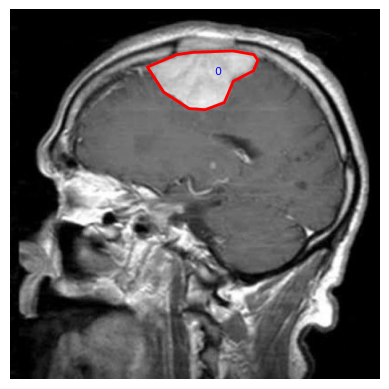

In [81]:
#I have to open the label data which appears to have information about a polygon around the tumor.
def load_polygon_from_file(file_path):
    """Parse a label file to extract polygon points and labels."""
    with open(file_path, 'r') as f:
        lines = f.readlines()
        polygon_points = []
        labels = []
        for line in lines:
            values = line.strip().split(' ')
            coords = list(map(float, values[1:]))
            points = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
            polygon_points.append(points)
            labels.append(values[0])  # Assuming first value is the label
    return polygon_points, labels


def scale_polygons_to_image(polygons, img_width, img_height):
    """Scale polygons to the image dimensions."""
    scaled_polygons = []
    for poly in polygons:
        scaled_poly = [(x * img_width, y * img_height) for x, y in poly]
        scaled_polygons.append(scaled_poly)
    return scaled_polygons


def plot_polygon_on_image(image_path, polygons, labels=None):
    """Plot polygons on an image."""
    img = Image.open(image_path)
    img_width, img_height = img.size
    plt.imshow(img)
    for i, points in enumerate(polygons):
        polygon = Polygon(points, edgecolor='r', fill=None, linewidth=2)
        plt.gca().add_patch(polygon)
        if labels:
            centroid = np.mean(points, axis=0)
            plt.text(centroid[0], centroid[1], labels[i], color='blue', fontsize=8)
    plt.axis('off')
    plt.show()


# Paths
labels_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/labels"
images_folder = "/Users/ofrioren/GIT/Capstone III/brain_tumor_dataset/brain_tumor_segmentation/train/images"

# Iterate through label files
for label_file in os.listdir(labels_folder):
    if label_file.endswith('.txt'):
        # Load polygons and labels
        label_path = os.path.join(labels_folder, label_file)
        polygons, labels = load_polygon_from_file(label_path)
        
        # Find the corresponding image file
        image_file = label_file.replace('.txt', '.jpg')  # Adjust extension as needed
        image_path = os.path.join(images_folder, image_file)
        
        if os.path.exists(image_path):
            # Load image dimensions
            img = Image.open(image_path)
            img_width, img_height = img.size
            
            # Scale polygons to match image dimensions
            scaled_polygons = scale_polygons_to_image(polygons, img_width, img_height)
            
            # Plot polygons on the image
            print(f"Displaying {image_file} with polygons")
            plot_polygon_on_image(image_path, scaled_polygons, labels)
            break  # Display only the first image for examination
        else:
            print(f"Image not found for label file: {label_file}")


In [ ]:
#Even though the image slices of the brain are from different angles, I already have information with polygons to 
# identify the tumors. This is an example of supervised learning and I will use this information to train a machine 
# to correctly identify tumors based on this data. In this dataset much of the wrangling and image processing is already
# done; however, the bulk of the work was not done upfront and it will take a fair amount of work to train a machine 
# learning system to identify tumors correctly from the test group and I also hope to have new images to test.